In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cifar10_input

class Attack:
    def __init__(self, model, tol, num_steps, step_size, random_start):
        self.model = model
        self.tol = tol
        self.num_steps = num_steps
        self.step_size = step_size
        self.rand = random_start

        self.xs = tf.Variable(np.zeros((1, 32, 32, 3), dtype=np.float32),
                                    name='modifier')
        self.orig_xs = tf.placeholder(tf.float32, [None, 32, 32, 3])

        self.ys = tf.placeholder(tf.int32, [None])

        self.epsilon = 8

        delta = tf.clip_by_value(self.xs, 0, 255) - self.orig_xs
        delta = tf.clip_by_value(delta, -self.epsilon, self.epsilon)

        self.do_clip_xs = tf.assign(self.xs, self.orig_xs+delta)

        self.logits = logits = model(self.xs)

        label_mask = tf.one_hot(self.ys, 10)
        correct_logit = tf.reduce_sum(label_mask * logits, axis=1)
        wrong_logit = tf.reduce_max((1-label_mask) * logits - 1e4*label_mask, axis=1)

        self.loss = (correct_logit - wrong_logit)

        start_vars = set(x.name for x in tf.global_variables())
        optimizer = tf.train.AdamOptimizer(step_size*1)

        grad,var = optimizer.compute_gradients(self.loss, [self.xs])[0]
        self.train = optimizer.apply_gradients([(tf.sign(grad),var)])

        end_vars = tf.global_variables()
        self.new_vars = [x for x in end_vars if x.name not in start_vars]

    def perturb(self, x, y, sess):
        sess.run(tf.variables_initializer(self.new_vars))
        sess.run(self.xs.initializer)
        sess.run(self.do_clip_xs,
                 {self.orig_xs: x})

        for i in range(self.num_steps):

            sess.run(self.train, feed_dict={self.ys: y})
            sess.run(self.do_clip_xs,
                     {self.orig_xs: x})

        return sess.run(self.xs)


from cifar_model import Model

cifar = cifar10_input.CIFAR10Data("../cifar10_data")

sess = tf.Session()
model = Model("../models/standard/", tiny=False, mode='eval', sess=sess)
attack = Attack(model,
                      1,
                      100,
                      1,
                      False)


/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
INFO:tensorflow:Restoring parameters from ../models/standard/checkpoint-68000


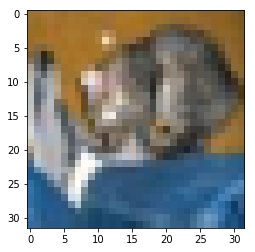

Image Label [3]
Clean Model Prediction [3]
	Logits [[-2.943294    0.46478105 -0.8648879  19.721521   -3.7883172  -0.8003821
  -0.39915484 -6.370495   -3.8886895  -1.1313981 ]]


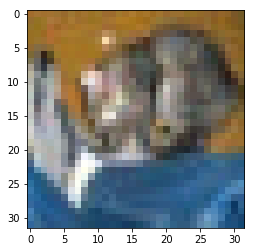

Max distortion 0.015686304195254464
Adversarial Model Prediction [1]
	Logits [[-0.9947913 26.722824  -4.859945  -8.837139  -5.355517  -1.1278083
  -1.69133   -5.736787  -3.6843789  5.5629673]]


In [2]:
xs = tf.placeholder(tf.float32, (1, 32, 32, 3))

image = cifar.eval_data.xs[:1]
label = cifar.eval_data.ys[:1]

plt.imshow(image[0]/255.0)
plt.show()
print("Image Label", label)

print('Clean Model Prediction',
      sess.run(model.predictions, {model.x_input: image}))
print('\tLogits',
      sess.run(model.pre_softmax, {model.x_input: image}))

adversarial = attack.perturb(image, label, sess)

plt.imshow(adversarial[0]/255.0)
plt.show()

print("Max distortion", np.max(np.abs(adversarial/255.0-image/255.0)))

print('Adversarial Model Prediction',
      sess.run(model.predictions, {model.x_input: adversarial}))
print('\tLogits',
      sess.run(model.pre_softmax, {model.x_input: adversarial}))
